In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import copy
import folium
import re
from statistics import mean, stdev
import pyeasyga.pyeasyga as pyeasyga
from pyeasyga.pyeasyga import GeneticAlgorithm

In [3]:
#CARGA DE DATOS
#Se reutiliza el código de carga de datos del proyecto anterior

def load_distance_time_dic(path):
    data = pd.read_csv(path)
    distance = {}
    time = {}
    for i in range(len(data)):
        origen = int(data.iloc[i, 0])
        destino = int(data.iloc[i, 1])
        distance[origen, destino] = float(data.iloc[i, 2])/1000
        time[origen, destino] = float(data.iloc[i, 3])
    return distance, time
5
def load_vehicles(path):
    data = pd.read_csv(path)
    vehicles = {}
    for i in range(len(data)):
        id = int(data.iloc[i, 0])
        capacity = int(data.iloc[i, 1])
        ran = float(data.iloc[i, 2])
        vehicles[id] = (capacity, ran)
    return vehicles

def load_demand(path):
    data = pd.read_csv(path)
    demand_dic = {}
    for i in range(len(data)):
        id = int(data.iloc[i, 1])
        demand = float(data.iloc[i, 2])
        demand_dic[id] = demand
    return demand_dic

def load_coordinates(depotsPath, clientsPath):
    coord = {}
    depot = pd.read_csv(depotsPath)
    client = pd.read_csv(clientsPath)
    for i in range(len(depot)):
        id = int(depot.iloc[i, 1])
        lat = float(depot.iloc[i, 3])
        long = float(depot.iloc[i, 2])
        coord[id] = [lat, long]
    for j in range(len(client)):
        id = int(client.iloc[j, 1])
        lat = float(client.iloc[j, 4])
        long = float(client.iloc[j, 3])
        coord[id] = [lat, long]
    return coord


In [4]:
distancia,time_dic = load_distance_time_dic('../Datos/casoBase.csv')
vehiculos = load_vehicles('../Datos/vehicles.csv')
demanda = load_demand('../Datos/clients.csv')
coord = load_coordinates('../Datos/depots.csv', '../Datos/clients.csv')
print(f"Distancia: {distancia}")
print(f"Vehiculos: {vehiculos}")
print(f"Demanda: {demanda}")
print(f"Coordenadas: {coord}")
print(f"Time: {time_dic}")



Distancia: {(1, 2): 27.144299999999998, (1, 3): 17.6771, (1, 4): 13.9796, (1, 5): 26.6508, (1, 6): 22.5837, (1, 7): 18.5625, (1, 8): 24.765900000000002, (1, 9): 23.9294, (1, 10): 27.835900000000002, (1, 11): 33.6518, (1, 12): 31.029400000000003, (1, 13): 16.1247, (1, 14): 21.6122, (1, 15): 10.3874, (1, 16): 27.040200000000002, (1, 17): 33.9631, (1, 18): 26.5413, (1, 19): 20.0532, (1, 20): 21.278200000000002, (1, 21): 13.411200000000001, (1, 22): 27.8695, (1, 23): 24.2626, (1, 24): 11.364799999999999, (1, 25): 30.8098, (2, 1): 30.809900000000003, (2, 3): 14.2563, (2, 4): 19.400299999999998, (2, 5): 1.1309, (2, 6): 12.475100000000001, (2, 7): 11.4167, (2, 8): 16.8514, (2, 9): 13.820799999999998, (2, 10): 7.5098, (2, 11): 7.110399999999999, (2, 12): 10.8902, (2, 13): 24.4451, (2, 14): 7.9738999999999995, (2, 15): 20.1425, (2, 16): 1.2554, (2, 17): 7.4218, (2, 18): 4.283399999999999, (2, 19): 9.819600000000001, (2, 20): 15.2813, (2, 21): 23.0465, (2, 22): 21.1477, (2, 23): 5.482, (2, 24): 

In [39]:
depot_id = 1  # depósito con demanda 0
pf = 15000
ft = 5000
cm = 700
gv = 0.411458

class VRPGeneticAlgorithm:
    def __init__(self, distance, demand, vehicles, coord):
        self.distance = distance
        self.demand = demand
        self.vehicles = vehicles
        self.coord = coord
        self.clientes = [c for c in demand.keys() if c != depot_id]
        self.demand[depot_id] = 0
        
    def create_individual(self, data):
        """Crear un individuo (conjunto de rutas)"""
        n_vehiculos = len(self.vehicles)
        rutas = [[] for _ in range(n_vehiculos)]
        clientes_copy = self.clientes[:]
        random.shuffle(clientes_copy)
        
        # Asignar cada cliente exactamente a un vehículo (round robin)
        for idx, cliente in enumerate(clientes_copy):
            v_id = idx % n_vehiculos
            rutas[v_id].append(cliente)
        
        # Agregar depósito al inicio y fin de cada ruta
        rutas = [[depot_id] + ruta + [depot_id] if ruta else [] for ruta in rutas]
        return rutas

    def mutate_individual(self, individual, data=None):
        """Mutación: mover un cliente de un vehículo a otro"""
        nuevas_rutas = copy.deepcopy(individual)
        
        # Encontrar vehículos con rutas no vacías
        vehiculos_con_rutas = [i for i, ruta in enumerate(nuevas_rutas) if len(ruta) > 2]
        
        if len(vehiculos_con_rutas) < 2:
            return nuevas_rutas
        
        # Elegir dos vehículos distintos
        v1, v2 = random.sample(vehiculos_con_rutas, 2)
        
        if len(nuevas_rutas[v1]) > 2:
            # Seleccionar cliente aleatorio (excluyendo depósitos)
            cliente = random.choice(nuevas_rutas[v1][1:-1])
            nuevas_rutas[v1].remove(cliente)
            
            # Insertar cliente en posición aleatoria en v2
            if len(nuevas_rutas[v2]) == 0:
                nuevas_rutas[v2] = [depot_id, cliente, depot_id]
            else:
                pos = random.randint(1, len(nuevas_rutas[v2]) - 1)
                nuevas_rutas[v2].insert(pos, cliente)
        
        return nuevas_rutas

    def crossover_individuals(self, parent1, parent2, data=None):
        """Cruzamiento: intercambiar segmentos de rutas entre padres"""
        hijo1 = copy.deepcopy(parent1)
        hijo2 = copy.deepcopy(parent2)
        
        # Seleccionar vehículo aleatorio para cruzar
        v = random.randint(0, len(parent1) - 1)
        
        if len(parent1[v]) > 2 and len(parent2[v]) > 2:
            # Extraer rutas sin depósitos
            ruta1 = parent1[v][1:-1]
            ruta2 = parent2[v][1:-1]
            
            if ruta1 and ruta2:
                # Punto de cruce
                split1 = random.randint(0, len(ruta1))
                split2 = random.randint(0, len(ruta2))
                
                # Crear nuevas rutas cruzadas
                nueva_ruta1 = ruta1[:split1] + ruta2[split2:]
                nueva_ruta2 = ruta2[:split2] + ruta1[split1:]
                
                # Reconstruir rutas con depósitos
                hijo1[v] = [depot_id] + nueva_ruta1 + [depot_id] if nueva_ruta1 else []
                hijo2[v] = [depot_id] + nueva_ruta2 + [depot_id] if nueva_ruta2 else []
                
                # Limpiar duplicados y reasignar clientes faltantes
                hijo1 = self._reparar_solucion(hijo1)
                hijo2 = self._reparar_solucion(hijo2)
        
        return hijo1, hijo2

    def _reparar_solucion(self, rutas):
        """Reparar solución eliminando duplicados y asignando clientes faltantes"""
        # Encontrar todos los clientes asignados
        asignados = set()
        for ruta in rutas:
            for cliente in ruta:
                if cliente != depot_id:
                    asignados.add(cliente)
        
        # Eliminar duplicados
        rutas_limpias = []
        clientes_vistos = set()
        
        for ruta in rutas:
            nueva_ruta = [depot_id]
            for cliente in ruta[1:-1]:  # Excluir depósitos
                if cliente not in clientes_vistos:
                    nueva_ruta.append(cliente)
                    clientes_vistos.add(cliente)
            if len(nueva_ruta) > 1:
                nueva_ruta.append(depot_id)
                rutas_limpias.append(nueva_ruta)
            else:
                rutas_limpias.append([])
        
        # Asignar clientes faltantes
        faltantes = set(self.clientes) - clientes_vistos
        for cliente in faltantes:
            v_id = random.randint(0, len(rutas_limpias) - 1)
            if len(rutas_limpias[v_id]) == 0:
                rutas_limpias[v_id] = [depot_id, cliente, depot_id]
            else:
                rutas_limpias[v_id].insert(-1, cliente)
        
        return rutas_limpias

    def fitness_individual(self, individual, data):
        """Evaluar fitness de un individuo (menor es mejor)"""
        claves_vehiculos = list(self.vehicles.keys())
        total_cost = 0
        
        for v_id, ruta in enumerate(individual):
            if len(ruta) <= 2:  # Ruta vacía
                continue
                
            cap_max, rango_max = self.vehicles[claves_vehiculos[v_id]]
            carga = 0
            distancia_total = 0
            
            # Calcular distancia y carga de la ruta
            for i in range(len(ruta) - 1):
                a, b = ruta[i], ruta[i + 1]
                distancia_total += self.distance.get((a, b), 9999999)
                if b != depot_id:
                    carga += self.demand.get(b, 0)
            
            # Calcular penalizaciones por violación de restricciones
            penalizacion = 0
            if carga > cap_max:
                penalizacion += 1e6 * (carga - cap_max)
            if distancia_total > rango_max:
                penalizacion += 1e6 * (distancia_total - rango_max)
            
            # Costo total del vehículo
            costo_vehiculo = gv * pf * distancia_total + ft + cm + penalizacion
            total_cost += costo_vehiculo
        
        # pyeasyga maximiza fitness, por lo que devolvemos el negativo del costo
        return -total_cost

    def tournament_selection(self, population, tournament_size=3):
        """Selección por torneo"""
        def tournament_select():
            # Seleccionar individuos aleatorios para el torneo
            tournament = random.sample(population, min(tournament_size, len(population)))
            # Devolver el mejor individuo del torneo
            return max(tournament, key=lambda x: x.fitness)
        
        return tournament_select

    def _verificar_asignacion_completa(self, rutas):
        """Verificar que todos los clientes estén asignados"""
        asignados = set()
        for ruta in rutas:
            for cliente in ruta:
                if cliente != depot_id:
                    asignados.add(cliente)
        
        faltantes = set(self.clientes) - asignados
        return faltantes


def run_ga_pyeasyga(distance, demand, vehicles, coord, 
                            n_generaciones=200, n_poblacion=50, 
                            prob_mutacion=0.2, prob_cruzamiento=0.8,
                            elitismo=5, tournament_size=3):
    """
    Versión mejorada del algoritmo genético con pyeasyga
    """
    # Crear instancia del problema VRP con verificaciones extendidas
    vrp = VRPGeneticAlgorithm(distance, demand, vehicles, coord)
    
    # Configurar algoritmo genético
    ga = GeneticAlgorithm(
        seed_data=None,
        population_size=n_poblacion,
        generations=n_generaciones,
        crossover_probability=prob_cruzamiento,
        mutation_probability=prob_mutacion,
        elitism=True,
        maximise_fitness=True
    )
    
    # Asignar funciones personalizadas
    ga.create_individual = vrp.create_individual
    ga.mutate_function = vrp.mutate_individual
    ga.crossover_function = vrp.crossover_individuals
    ga.fitness_function = vrp.fitness_individual
    
    fitness_history = []

    # Sobrescribir el método rank_population para guardar el mejor fitness
    original_rank_population = ga.rank_population
    def rank_and_record():
        original_rank_population()
        # El mejor fitness está en la primera posición después de ordenar
        fitness_history.append(ga.current_generation[0].fitness)
    ga.rank_population = rank_and_record
    
    # Ejecutar algoritmo genético
    print("Iniciando algoritmo genético mejorado...")
    ga.run()
    
    # Obtener mejor solución
    mejor_solucion = ga.best_individual()[1]
    mejor_fitness = -ga.best_individual()[0]
    
    # Verificaciones finales
    faltantes = vrp._verificar_asignacion_completa(mejor_solucion)
    if faltantes:
        print(f"¡Atención! Algunos nodos no fueron asignados: {faltantes}")
    else:
        print("Todos los nodos fueron asignados correctamente.")
    
    print(f"Mejor costo: {mejor_fitness}")
    
    # Obtener historial de fitness
    fitness_history = [-fitness for fitness in fitness_history]
    
    return mejor_solucion, fitness_history

In [27]:
def visualizar_rutas_folium(rutas, coord):
    # Crear mapa centrado en depósito o promedio de coordenadas
    lat_dep, lon_dep = coord[depot_id]
    m = folium.Map(location=[lat_dep, lon_dep], zoom_start=11, tiles='Cartodb Positron')

    colors = ['blue', 'green', 'cyan', 'magenta','olive', 'blue', 'orange', 'purple','red']
    icons = ['blue', 'green', 'lightblue', 'pink','lightgreen', 'blue', 'orange', 'darkpurple','red']

    for v, ruta in enumerate(rutas):
        if not ruta or len(ruta) < 2:
            continue

        # Construir lista de coordenadas para PolyLine: [(lat, lon), (lat, lon), ...]
        coords_ruta = [coord[n] for n in ruta]

        # Dibujar la ruta
        folium.PolyLine(
            coords_ruta,
            color=colors[v % len(colors)],
            weight=5,
            opacity=0.7,
            tooltip=f'Vehículo {v}'
        ).add_to(m)

        # Marcador inicio (depósito)
        folium.Marker(
            coords_ruta[0],
            popup="Inicio (Depósito)",
            icon=folium.Icon(color='black', icon='home')
        ).add_to(m)

        # Marcador fin de ruta
        folium.Marker(
            coords_ruta[-1],
            popup=f"Llegada Vehículo {v}",
            icon=folium.Icon(color=icons[v % len(icons)], icon='flag')
        ).add_to(m)

    return m


In [40]:
solucion, evol = run_ga_pyeasyga(distancia, demanda, vehiculos, coord, n_generaciones=300)
mapa = visualizar_rutas_folium(solucion, coord)
mapa

Iniciando algoritmo genético mejorado...
Todos los nodos fueron asignados correctamente.
Mejor costo: 2000627.307153


## Visualización y estadísticas

In [31]:

def isClient(name):
    return bool(re.fullmatch(r'C\d+', name))

#SIN TERMINAR
def generateValidationFile(rutas, vehiculos, clientes):
    data = {
    'VehicleId':[] ,
    'DepotId':[] ,
    'InitialLoad':[] ,
    'RouteSequence':[] ,
    'ClientsServed':[] ,
    'DemandsSatisfied':[] , 
    'TotalDistance':[] , 
    'TotalTime':[] , 
    'FuelCost':[]
    }
    for ruta in rutas:
        print('r', ruta)
    for v in vehiculos:
        path = []
    
        print('v', v)
        data['VehicleId'].append("VEH" + "{:03d}".format(v))
        clients = 0
        demandas = []
        total_demand = 0
        for nodo in rutas[v-1]:
            if nodo == 1:
                path.append('CD1')
            else:
                path.append('C' + str(nodo))
                clients += 1
                demanda_c = demanda[nodo]
                print(demanda_c)
                demandas.append(str(demanda_c))
                total_demand += demanda_c
        print(demandas)
        data['RouteSequence'].append("-".join(path))
        data['ClientsServed'].append(clients)
        data['DepotId'].append('CD1')
        data['DemandsSatisfied'].append("-".join(demandas))
        data['InitialLoad'].append(total_demand)

        
        total_dist = 0
        t_time = 0
        ruta = rutas[v-1]
        for i in range(len(ruta) -1):
            total_dist += distancia[(ruta[i],ruta[i+1])]
            t_time += time_dic[(ruta[i],ruta[i+1])]
        t_time = t_time/60
        print(total_dist)
        print(t_time)



        data['TotalDistance'].append(round(total_dist,1))
        data['TotalTime'].append(round(t_time, 1))
        data['FuelCost'].append(round((total_dist)*pf))
        #print("time", t_time)

    print(data)
    df = pd.DataFrame(data)
    df.to_csv("verificacion_casoBase_metaheuristica_1.csv", index=False)
    
generateValidationFile(solucion, vehiculos, demanda)   

#print(data)

r [1, 23, 10, 12, 18, 6, 9, 1]
r [1, 24, 15, 5, 14, 8, 22, 20, 13, 21, 1]
r []
r [1, 2, 17, 11, 19, 4, 1]
r [1, 25, 16, 7, 3, 1]
r []
r []
r []
v 1
18.0
20.0
17.0
25.0
20.0
20.0
['18.0', '20.0', '17.0', '25.0', '20.0', '20.0']
85.63130000000001
129.25833333333333
v 2
15.0
15.0
15.0
21.0
17.0
14.0
11.0
12.0
15.0
['15.0', '15.0', '15.0', '21.0', '17.0', '14.0', '11.0', '12.0', '15.0']
92.6561
142.1216666666667
v 3
[]
0
0.0
v 4
13.0
10.0
15.0
12.0
12.0
['13.0', '10.0', '15.0', '12.0', '12.0']
79.3372
125.86999999999999
v 5
11.0
17.0
17.0
15.0
['11.0', '17.0', '17.0', '15.0']
75.9777
113.77999999999999
v 6
[]
0
0.0
v 7
[]
0
0.0
v 8
[]
0
0.0
{'VehicleId': ['VEH001', 'VEH002', 'VEH003', 'VEH004', 'VEH005', 'VEH006', 'VEH007', 'VEH008'], 'DepotId': ['CD1', 'CD1', 'CD1', 'CD1', 'CD1', 'CD1', 'CD1', 'CD1'], 'InitialLoad': [120.0, 135.0, 0, 62.0, 60.0, 0, 0, 0], 'RouteSequence': ['CD1-C23-C10-C12-C18-C6-C9-CD1', 'CD1-C24-C15-C5-C14-C8-C22-C20-C13-C21-CD1', '', 'CD1-C2-C17-C11-C19-C4-CD1', 'CD1-C

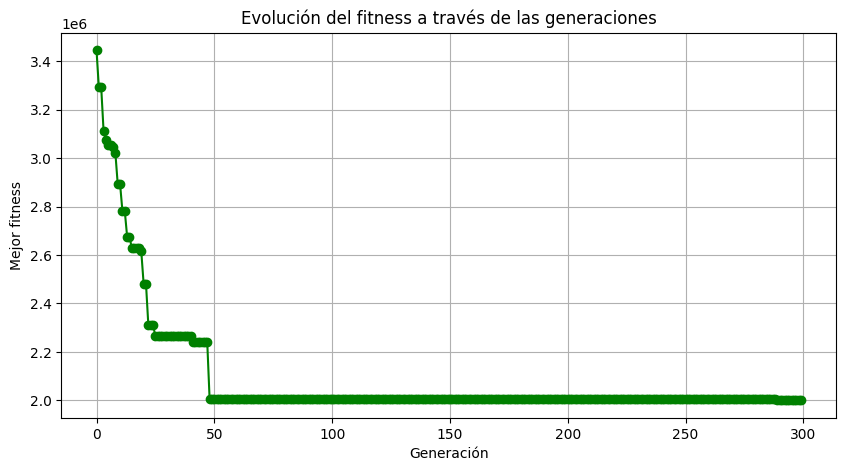

Costo total: 2029127.307153
Costo promedio por vehículo: 253640.913394125
Desviación estándar de costos: 328539.98295641755


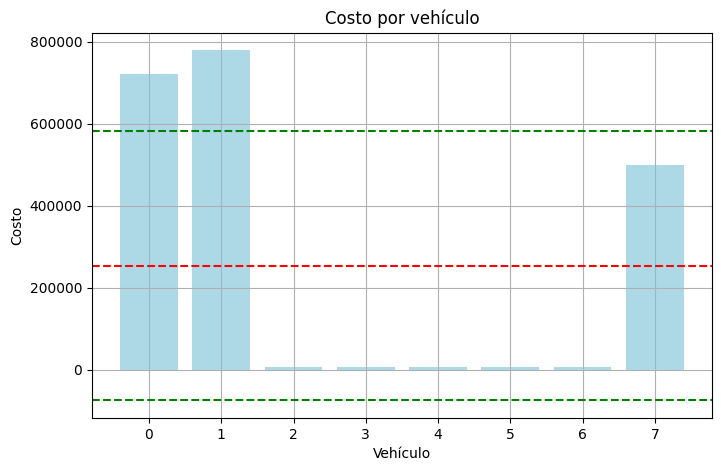

In [41]:

def graficar_costos_por_vehiculo(rutas, distancia, pf, ft, cm, gv):
    costos =[]
    for ruta in rutas:
        distance = 0
        for i in range(len(ruta)-1):
            distance += distancia[(ruta[i], ruta[i+1])]
        costo = gv*pf * distance + ft + cm
        costos.append(costo)
    media =  np.mean(costos)
    dev_est = np.std(costos) 
    print("Costo total:", sum(costos))
    print("Costo promedio por vehículo:", media)
    print("Desviación estándar de costos:", dev_est)

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(costos)), costos, color='lightblue')
    plt.axhline(y=media, color='r', linestyle='dashed')
    plt.axhline(y=media+dev_est, color='g', linestyle='dashed')
    plt.axhline(y=media-dev_est, color='g', linestyle='dashed')
    plt.xlabel('Vehículo')
    plt.ylabel('Costo')
    plt.title('Costo por vehículo')
    plt.grid(True)
    plt.show()


def graficar_evolucion_fitness(mejores_costos):
    plt.figure(figsize=(10, 5))
    plt.plot(mejores_costos, marker='o', color='green')
    plt.xlabel('Generación')
    plt.ylabel('Mejor fitness')
    plt.title('Evolución del fitness a través de las generaciones')
    plt.grid(True)
    plt.show()

graficar_evolucion_fitness(evol)
graficar_costos_por_vehiculo(solucion, distancia, pf, ft, cm, gv)


## Analisis de Escalabilidad

## Comparación son soluciones previas (Pyomo)